# **Lendo o conjunto de dados**

In [37]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
df = pd.read_csv('/content/df_churn.csv')

In [3]:
df.head()

,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges_monthly,charges_total,charges_daily,churn_bin
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,0
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,0
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,1
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,1
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,1


# **Limpando os dados**

In [4]:
df_churn = df.drop(['customerid','churn'], axis=1)
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   object 
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   phoneservice      7032 non-null   object 
 6   multiplelines     7032 non-null   object 
 7   internetservice   7032 non-null   object 
 8   onlinesecurity    7032 non-null   object 
 9   onlinebackup      7032 non-null   object 
 10  deviceprotection  7032 non-null   object 
 11  techsupport       7032 non-null   object 
 12  streamingtv       7032 non-null   object 
 13  streamingmovies   7032 non-null   object 
 14  contract          7032 non-null   object 
 15  paperlessbilling  7032 non-null   object 
 16  paymentmethod     7032 non-null   object 


# **Separar variavies categoricas e Numéricas**

In [5]:
def detec_auto(data: pd.DataFrame):
    bool_like = []
    for col in data.columns:
        if data[col].dtype == 'object':
            vals = data[col].dropna().astype(str).str.lower().unique()
            if set(vals).issubset({'yes','no','y','n','true','false','sim','não','nao'}):
                bool_like.append(col)


    num_cols_auto = data.select_dtypes(include=['number']).columns.tolist()
    cat_cols_auto = list(set(data.columns) - set(num_cols_auto))

    for col in bool_like:
        if col not in cat_cols_auto:
            cat_cols_auto.append(col)
        if col in num_cols_auto:
            num_cols_auto.remove(col)

    #checagem se todas as colunas foram tratadas
    print(f'Quantidade de Variaveis: {len(data.columns)}\n')
    print(f'Quantidade de Variaveis Númericas identificadas: {len(num_cols_auto)}')
    print('\n'.join([f' {i}' for i in num_cols_auto]))
    print('-'*120)
    print(f'Quantidade de Variaveis Categoricas identificadas: {len(cat_cols_auto)}')
    print('\n'.join([f' {i}' for i in cat_cols_auto]))

    return num_cols_auto, cat_cols_auto

In [6]:
numeric_cols, categorical_cols = detec_auto(df_churn)

Quantidade de Variaveis: 21

Quantidade de Variaveis Númericas identificadas: 5
 tenure
 charges_monthly
 charges_total
 charges_daily
 churn_bin
------------------------------------------------------------------------------------------------------------------------
Quantidade de Variaveis Categoricas identificadas: 16
 phoneservice
 streamingmovies
 paymentmethod
 onlinebackup
 seniorcitizen
 partner
 paperlessbilling
 onlinesecurity
 gender
 dependents
 contract
 streamingtv
 techsupport
 deviceprotection
 multiplelines
 internetservice


# **Encoding variaveis categoricas**

In [7]:
df_encoded = pd.get_dummies(df_churn, columns=categorical_cols, dtype=int, drop_first=True)
df_encoded.head()

,tenure,charges_monthly,charges_total,charges_daily,churn_bin,phoneservice_Yes,streamingmovies_No internet service,streamingmovies_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,streamingtv_No internet service,streamingtv_Yes,techsupport_No internet service,techsupport_Yes,deviceprotection_No internet service,deviceprotection_Yes,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,internetservice_No
0,9,65.6,593.30,2.186667,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,9,59.9,542.40,1.996667,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,73.9,280.85,2.463333,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,13,98.0,1237.85,3.266667,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,3,83.9,267.40,2.796667,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


# **Verificar balanceamento da variável alvo**

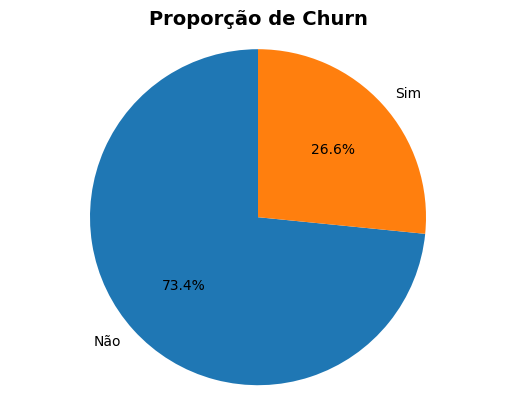

In [8]:
labels = ['Não', 'Sim']
sizes = df_encoded['churn_bin'].value_counts().sort_index()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proporção de Churn', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

# **Separação de Dados**

In [9]:
X = df_encoded.drop(columns=['churn_bin'])
y = df_encoded['churn_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Tamanho do conjunto de Treino:\nX_train: {X_train.shape}\ny_train: {y_train.shape}\n')
print(f'Tamanho do conjunto de Teste:\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

Tamanho do conjunto de Treino:
X_train: (5625, 31)
y_train: (5625,)

Tamanho do conjunto de Teste:
X_test: (1407, 31)
y_test: (1407,)


# **Balanceamento de Classes**

Em analise anterior observamos que os dados estavam muito desbalanceado, sendo 73,4% dos dados de clientes que permanece na empresa e 26,6% de clientes que sairam da empresa.

Foi utilizado do SMOTE, que gera amostras sintéticas dos dados para o balanceamento das classes.

<mark> **Atenção**: O balanceamento foi feito apenas no conjunto de treino!</mark>

In [10]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print('Antes do balanceamento:', y_train.value_counts(), '\n')
print('Depois do balanceamento:', y_train_bal.value_counts())

Antes do balanceamento: churn_bin
0    4130
1    1495
Name: count, dtype: int64 

Depois do balanceamento: churn_bin
0    4130
1    4130
Name: count, dtype: int64


# **Modelagem Preditiva**

## **Base Line**

In [15]:
def treinar_avaliar_baseline(models, X_train, y_train, X_test, y_test):
    resultados = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)

        print(f'Modelo: {name}\n')
        print(f'Recall:   {rec:.4f}')
        print(f'F1-score: {f1:.4f}')
        print(f'Precisão: {prec:.4f}')
        print(f'Acurácia: {acc:.4f}')
        print('-'*70)

        resultados.append({
            'model': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

    return resultados

In [25]:
# Regressão Logística
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

# KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Random Forest
rf = RandomForestClassifier()

# GradientBosting
gbc = GradientBoostingClassifier()

models = {'LogisticRegression': pipe_lr, 'KNeighborsClassifier': pipe_knn, 'RandomForest': rf, 'GradientBosting': gbc }

In [26]:
metric_baseline = treinar_avaliar_baseline(models, X_train_bal, y_train_bal, X_test, y_test)

Modelo: LogisticRegression

Recall:   0.6524
F1-score: 0.6055
Precisão: 0.5648
Acurácia: 0.7740
----------------------------------------------------------------------
Modelo: KNeighborsClassifier

Recall:   0.6444
F1-score: 0.5618
Precisão: 0.4979
Acurácia: 0.7328
----------------------------------------------------------------------
Modelo: RandomForest

Recall:   0.6016
F1-score: 0.5806
Precisão: 0.5611
Acurácia: 0.7690
----------------------------------------------------------------------
Modelo: GradientBosting

Recall:   0.6952
F1-score: 0.6125
Precisão: 0.5474
Acurácia: 0.7662
----------------------------------------------------------------------


## **Validação Cruzada**

In [45]:
def treinar_avaliar_modelos_cv(models, n_splits, scoring, X_train, y_train, X_test, y_test):
    resultados = []

    for name, model in models.items():
        cv = StratifiedKFold(n_splits, shuffle=True, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

        acc = cv_results['test_accuracy'].mean()
        prec = cv_results['test_precision'].mean()
        rec = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()

        print(f'Modelo: {name}\n')
        print(f'Recall médio: {rec:.4f}')
        print(f'F1-score médio: {f1:.4f}')
        print(f'Precisão média: {prec:.4f}')
        print(f'Acurácia média: {acc:.4f}')
        print('-'*70)

        resultados.append({
            'model': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

    return resultados

In [46]:
new_models = {
    'LogisticRegression': ImbPipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNeighborsClassifier': ImbPipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('smote', SMOTE(random_state=42)),
        ('clf', KNeighborsClassifier())
    ]),
    'RandomForest': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'GradientBoosting': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
}

In [47]:
scoring = {
    'recall': 'recall',
    'f1': 'f1',
    'precision': 'precision',
    'accuracy': 'accuracy'
}

metric_cv = treinar_avaliar_modelos_cv(new_models, 5, scoring, X_train, y_train, X_test, y_test)

Modelo: LogisticRegression

Recall médio: 0.7960
F1-score médio: 0.6328
Precisão média: 0.5252
Acurácia média: 0.7545
----------------------------------------------------------------------
Modelo: KNeighborsClassifier

Recall médio: 0.7130
F1-score médio: 0.5458
Precisão média: 0.4422
Acurácia média: 0.6844
----------------------------------------------------------------------
Modelo: RandomForest

Recall médio: 0.5766
F1-score médio: 0.5735
Precisão média: 0.5710
Acurácia média: 0.7723
----------------------------------------------------------------------
Modelo: GradientBoosting

Recall médio: 0.6749
F1-score médio: 0.6116
Precisão média: 0.5595
Acurácia média: 0.7723
----------------------------------------------------------------------


## **Melhores Parametros com GridSearchCV**

In [48]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [100, 200, 300]
    }

pipe_lr = new_models['LogisticRegression']

model_grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring='recall',
    cv=cv
    )

model_grid_lr.fit(X_train, y_train)
y_pred_lr = model_grid_lr.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

metric_grid_lr = {
    'model': 'LogisticRegression',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Melhores parâmetros: {model_grid_lr.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Melhores parâmetros: {'clf__C': 0.1, 'clf__max_iter': 100, 'clf__solver': 'lbfgs'}
Recall:   0.7995
F1-Score: 0.6321
Precisão: 0.5227
Acurácia: 0.7527


In [52]:
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
    }

pipe_knn = new_models['KNeighborsClassifier']

model_grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='recall',
    cv=cv
    )

model_grid_knn.fit(X_train, y_train)
y_pred_knn = model_grid_knn.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn)
rec = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

metric_grid_knn = {
    'model': 'KNeighborsClassifier',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Melhores parâmetros: {model_grid_knn.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Melhores parâmetros: {'clf__n_neighbors': 15, 'clf__p': 2, 'clf__weights': 'uniform'}
Recall:   0.8102
F1-Score: 0.5844
Precisão: 0.4570
Acurácia: 0.6937


In [54]:
param_grid_rf = {
    'clf__max_depth': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__min_samples_split': [2, 3, 4],
    'clf__n_estimators': [100, 150, 200, 300]
    }

pipe_rf = new_models['RandomForest']

model_grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='recall',
    cv=cv
    )

model_grid_rf.fit(X_train, y_train)
y_pred_rf = model_grid_rf.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

metric_grid_rf = {
    'model': 'RandomForest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Melhores parâmetros: {model_grid_rf.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Melhores parâmetros: {'clf__max_depth': 2, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Recall:   0.7941
F1-Score: 0.6030
Precisão: 0.4861
Acurácia: 0.7221


In [ ]:
param_grid_gbc = {
    'clf__max_depth': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__min_samples_split': [2, 3, 4],
    'clf__n_estimators': [100, 150, 200, 300]
    }

pipe_gbc = new_models['GradientBoosting']

model_grid_gbc = GridSearchCV(
    estimator=pipe_gbc,
    param_grid=param_grid_gbc,
    scoring='recall',
    cv=cv
    )

model_grid_gbc.fit(X_train, y_train)
y_pred_gbc = model_grid_gbc.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_gbc)
prec = precision_score(y_test, y_pred_gbc)
rec = recall_score(y_test, y_pred_gbc)
f1 = f1_score(y_test, y_pred_gbc)

metric_grid_gbc = {
    'model': 'GradientBoosting',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Melhores parâmetros: {model_grid_gbc.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

In [ ]:
def to_df(obj, stage):
    if isinstance(obj, list):
        df = pd.DataFrame(obj)
    else:  # dict único
        df = pd.DataFrame([obj])
    df["stage"] = stage
    return df

In [ ]:
dfs = []
dfs.append(to_df(metric_baseline, 'Baseline'))
dfs.append(to_df(metric_cv,       'CV (5-fold)'))
dfs.append(to_df(metric_grid_lr,  'Grid LR'))
dfs.append(to_df(metric_grid_knn, 'Grid KNN'))
dfs.append(to_df(metric_grid_rf,  'Grid RF'))
dfs.append(to_df(metric_grid_gbc, 'Grid GB'))

metrics_df = pd.concat(dfs, ignore_index=True)

cols = ['model', 'stage', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = metrics_df[cols]

metrics_df.head()

In [ ]:
stage_order = ['Baseline', 'CV (5-fold)', 'Grid LR', 'Grid KNN', 'Grid RF', 'Grid GB']

metrics_df['stage'] = pd.Categorical(metrics_df['stage'], categories=stage_order, ordered=True)

models = metrics_df['model'].unique()
metrics = ['accuracy', 'precision', 'recall', 'f1']

for m in metrics:
    pivot = metrics_df.pivot_table(index='model', columns='stage', values=m)
    pivot = pivot.reindex(models)
    ax = pivot.plot(kind='bar', figsize=(9, 5))
    ax.set_title(f'Comparação de {m.upper()} por modelo')
    ax.set_xlabel('Modelo')
    ax.set_ylabel(m.upper())
    ax.legend(title='Fase', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
